## Train Classifier: BERT

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, load_dataset, load_from_disk, concatenate_datasets
from sklearn.metrics import accuracy_score
import random
import numpy as np
import torch
import os

/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
topics = ["cannabis", "energie", "kinder"]

## Load Dataset

In [3]:
id_to_class = {0: "other",1: "cannabis", 2: "energie", 3: "kinder"}
class_to_id = {"other": 0, "cannabis": 1, "energie": 2, "kinder": 3}

In [4]:
dataset_cannabis = load_from_disk(f"../data/tmp/processed_dataset_cannabis_buffed")
dataset_energie = load_from_disk(f"../data/tmp/processed_dataset_energie_buffed")
dataset_kinder = load_from_disk(f"../data/tmp/processed_dataset_kinder_buffed")

In [5]:
from datasets import ClassLabel, Features, Value, DatasetDict, concatenate_datasets, load_dataset
import datasets

# Define the new class label feature
class_labels = ClassLabel(names=["other", "cannabis", "energie", "kinder"])

# Define the new features, including all existing ones plus the updated 'label'
new_features = datasets.Features({
    '_id': datasets.Value('string'),
    'batch_id': datasets.Value('int64'),
    'domain': datasets.Value('string'),
    'view_url': datasets.Value('string'),
    'lang': datasets.Value('string'),
    'text': datasets.Value('string'),
    'text_length': datasets.Value('int64'),
    'word_count': datasets.Value('int64'),
    'is_topic': datasets.Value('int64'),
    'label': class_labels # Use the updated ClassLabel feature
})

# Function to update the dataset with new features
def update_dataset_schema(dataset):
    return dataset.cast(new_features)

# Assuming dataset_cannabis, dataset_energie, dataset_kinder are loaded and need schema updates
dataset_cannabis = update_dataset_schema(dataset_cannabis.map(lambda e: {'label': class_to_id['cannabis'] if e["label"] == 1 else class_to_id['other']}, features=new_features))

dataset_energie = update_dataset_schema(dataset_energie.map(lambda e: {'label': class_to_id['energie'] if e["label"] == 1 else class_to_id['other']}, features=new_features))

dataset_kinder = update_dataset_schema(dataset_kinder.map(lambda e: {'label': class_to_id['kinder'] if e["label"] == 1 else class_to_id['other']}, features=new_features))


In [6]:
# Concatenate all datasets
dataset_all_topics = concatenate_datasets([dataset_cannabis, dataset_energie, dataset_kinder])

In [7]:
dataset_all_topics

Dataset({
    features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'is_topic', 'label'],
    num_rows: 452657
})

In [8]:
dataset_all_topics[0]

{'_id': '64a0946b749484eec84dbcc0',
 'batch_id': 16,
 'domain': 'bilendi.com',
 'view_url': 'surveyd.bilendi.com/survey/selfserve/53b/2306124',
 'lang': 'de',
 'text': " Die URL oben enthält nicht die für diese Umfrage erforderlichen Informationen. Die korrekte URL finden Sie in Ihrer Einladungs-E-Mail. Wenn die Probleme weiterhin auftreten, wenden Sie sich bitte an die dort angegebene Person. ERROR: SE-02 Variable list has invalid value '' ",
 'text_length': 276,
 'word_count': 43,
 'is_topic': 0,
 'label': 0}

In [9]:
# Filter positive and negative examples
dataset_all_topics_pos = dataset_all_topics.filter(lambda example: example['label'] > 0, num_proc=16)
dataset_all_topics_neg = dataset_all_topics.filter(lambda example: example['label'] == 0, num_proc=16)

In [10]:
# Collect all view_url values from dataset_all_topics_pos
pos_view_urls = set(dataset_all_topics_pos['view_url'])

# Filter dataset_all_topics_neg to exclude any rows present in dataset_all_topics_pos
dataset_all_topics_neg = dataset_all_topics_neg.filter(lambda example: example['view_url'] not in pos_view_urls, num_proc=16)


In [11]:
dataset_all_topics_neg

Dataset({
    features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'is_topic', 'label'],
    num_rows: 450095
})

## Deduplicate Negative Examples

In [12]:
seen_urls = set()

dataset_all_topics_neg = dataset_all_topics_neg.filter(lambda example: example['view_url'] not in seen_urls and not seen_urls.add(example['view_url']), num_proc=16)

## Sample Negative Examples

In [13]:
print("Number of distinct domains", len(set(dataset_all_topics_neg["domain"])))

Number of distinct domains 10666


In [14]:
# Step 1: Calculate domain frequencies
from collections import Counter

domain_counts = Counter(dataset_all_topics_neg['domain'])

N = 512  # Keep the top 512 most frequent domains
top_domains = set([domain for domain, count in domain_counts.most_common(N)])

# Step 2: Mark all other domains as "other"
def group_domains(example):
    if example['domain'] not in top_domains:
        example['domain'] = 'other'
    return example

# Apply the transformation to the dataset

dataset_all_topics_neg = dataset_all_topics_neg.map(group_domains)

In [15]:
from sklearn.model_selection import train_test_split

# Convert to Pandas DataFrame
df_dataset = dataset_all_topics_neg.to_pandas()  

sample_size = len(dataset_all_topics_pos)
print("Positive Sample size:", sample_size)

# Perform stratified sampling 
_ , stratified_sample = train_test_split(df_dataset, test_size=sample_size, stratify=df_dataset['domain'], random_state=42)
stratified_sample.reset_index(drop=True, inplace=True)

stratified_sample.head()

Positive Sample size: 2562


,_id,batch_id,domain,view_url,lang,text,text_length,word_count,is_topic,label
0,64a0946b749484eec84fb18a,16,other,gssteinhagen.de/iserv/mail?path=INBOX&msg=489&...,de,IServ-Anmeldung Sie haben keine Cookies aktiv...,196,26,0,0
1,64a0946c749484eec85270d4,16,other,ritterrost-magicpark.de,de,Home Park erkunden Back Parkplan Der Park Att...,5978,842,0,0
2,64a0946f749484eec85b605e,16,google.com,contacts.google.com/person/c418482573877722737,en,Sign in Use your Google Account Email or phone...,991,136,0,0
3,648c2ad88e8cadbd2901131f,15,yoursurveynow.com,survey-uk.yoursurveynow.com/survey/selfserve/5...,en,The unique number that tracks your progress t...,195,34,0,0
4,64a0946d749484eec854b468,16,youtube.com,www.youtube.com/@snakedocg8,de,Anmelden ein Google-Unternehmen Anmelden Bevor...,3342,426,0,0


In [16]:
dataset_all_topics_neg_sampled = Dataset.from_pandas(stratified_sample)
dataset_all_topics_neg_sampled = dataset_all_topics_neg_sampled.cast(new_features)

Casting the dataset: 100%|██████████| 2562/2562 [00:00<00:00, 58285.82 examples/s]


In [17]:
# Concatenate all datasets
dataset_all_topics = concatenate_datasets([dataset_all_topics_pos, dataset_all_topics_neg_sampled])

In [18]:
dataset_all_topics

Dataset({
    features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'is_topic', 'label'],
    num_rows: 5124
})

In [19]:
split_datasets = dataset_all_topics.train_test_split(test_size=0.1, shuffle=True)

In [20]:
print("Size of training set:", len(split_datasets['train']))
print("Size of testing set:", len(split_datasets['test']))

Size of training set: 4611
Size of testing set: 513


## Chunkify Examples

In [21]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter

In [22]:
MODEL_NAME = "deepset/gbert-large"
MAX_CONTENT_LENGTH = 512
OVERLAP = 50

# Load a pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [23]:
def get_input_length(text):
    """ Tokenize the input text and return the number of tokens """
    return len(tokenizer.encode(text, add_special_tokens=True, truncation=False, padding=False))

print(get_input_length("Hello, my name is John Doe"))

12


In [24]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=MAX_CONTENT_LENGTH,
    chunk_overlap=OVERLAP,
    length_function=get_input_length,
    separators = ["\n\n", "\n", ".", "?", "!", " ", ""]
)

# text_splitter = CharacterTextSplitter(
#     separator = ".", # Split text by sentences
#     chunk_size=MAX_CONTENT_LENGTH,
#     chunk_overlap=OVERLAP,
#     length_function=get_input_length,
#     is_separator_regex=False,
# )

In [25]:
test_text = split_datasets['train'][0]['text']
print(test_text)

 Zum Hauptinhalt springen Zur Suche springen Zweites Deutsches Fernsehen Menü Hauptnavigation Startseite Rubriken Filme Serien Comedy & Satire heute-Nachrichten Politik & Gesellschaft Sport Dokus & Reportagen Kultur ZDFtivi für Kinder Sendungen A-Z TV-Programm Karriere im ZDF Barrierefrei Live-TV Sendung verpasst Dunkler Modus Heller Modus Suche Mein ZDF Meine Merkliste Weiterschauen Benachrichtigungen Mein ZDFtivi Einstellungen Anmelden abmelden Suche Suchbegriff Suchen Gesamtes Angebot ZDF ZDFinfo ZDFneo ZDFheute ZDFkultur ZDFtivi 3sat Arte Funk Kika Phoenix Weitere Filter von bis ganze Sendungen AD UT DGS Erste Schritte zum legalen Kiffen ZDFheute Ukraine Klimawandel Politik Wirtschaft Panorama Sport Digitales Wetter Nachrichten-Ticker Korrekturen & mehr Themen Sie sind hier: zdf.de Nachrichten Politik Cannabis-Legalisierung: Alles Wichtige zum Lauterbach-Plan Lauterbach plant Cannabis-Clubs : Erste Schritte zum legalen Kiffen Datum: 12.04.2023 14:44 Uhr Karl Lauterbach und Cem Özde

In [26]:
texts = text_splitter.split_text(test_text)
print(len(texts)) 

print(texts[0])
print("Length of text:", get_input_length(texts[0]))


7
Zum Hauptinhalt springen Zur Suche springen Zweites Deutsches Fernsehen Menü Hauptnavigation Startseite Rubriken Filme Serien Comedy & Satire heute-Nachrichten Politik & Gesellschaft Sport Dokus & Reportagen Kultur ZDFtivi für Kinder Sendungen A-Z TV-Programm Karriere im ZDF Barrierefrei Live-TV Sendung verpasst Dunkler Modus Heller Modus Suche Mein ZDF Meine Merkliste Weiterschauen Benachrichtigungen Mein ZDFtivi Einstellungen Anmelden abmelden Suche Suchbegriff Suchen Gesamtes Angebot ZDF ZDFinfo ZDFneo ZDFheute ZDFkultur ZDFtivi 3sat Arte Funk Kika Phoenix Weitere Filter von bis ganze Sendungen AD UT DGS Erste Schritte zum legalen Kiffen ZDFheute Ukraine Klimawandel Politik Wirtschaft Panorama Sport Digitales Wetter Nachrichten-Ticker Korrekturen & mehr Themen Sie sind hier: zdf.de Nachrichten Politik Cannabis-Legalisierung: Alles Wichtige zum Lauterbach-Plan Lauterbach plant Cannabis-Clubs : Erste Schritte zum legalen Kiffen Datum: 12.04.2023 14:44 Uhr Karl Lauterbach und Cem Özd

In [27]:
def expandRow(row, col_name):
    """
    Generate prompts based on text chunks from the input row.
    """
    rows = []

    # Split the text into chunks
    text_chunks = text_splitter.split_text(row.get(col_name, ""))

    # Generate prompts for each text chunk
    for chunk_id, text_chunk in enumerate(text_chunks):
        new_row = {
            **row, 'chunk_id': chunk_id, 'text': text_chunk
        }
        rows.append(new_row)

    return rows

In [28]:
from multiprocessing import Pool


def processDataset(dataset, num_processes, func, params=()):
    """Process a list of articles in parallel using a multiprocessing Pool."""

    # Creates a list of arguments for each call to func
    # Uses starmap to pass multiple arguments to func
    with Pool(processes=num_processes) as pool:
        args = [(row,) + params for row in dataset]
        dataset = list(pool.starmap(func, args))

    # Flatten the resulting list of lists
    # and convert it into a Dataset
    dataset = [item for sublist in dataset for item in sublist]
    dataset = Dataset.from_dict(
        {key: [dic[key] for dic in dataset] for key in dataset[0]})

    return dataset

In [29]:
split_datasets

DatasetDict({
    train: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'is_topic', 'label'],
        num_rows: 4611
    })
    test: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'is_topic', 'label'],
        num_rows: 513
    })
})

In [30]:
num_processes = 24
params = ("text",)

for split in split_datasets:
    split_datasets[split] = processDataset(split_datasets[split], num_processes, expandRow, params)

Token indices sequence length is longer than the specified maximum sequence length for this model (2700 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2384 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (888 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (570 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

In [31]:
split_datasets

DatasetDict({
    train: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'is_topic', 'label', 'chunk_id'],
        num_rows: 36857
    })
    test: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'is_topic', 'label', 'chunk_id'],
        num_rows: 3716
    })
})

In [32]:
split_datasets["train"][0]

{'_id': '64a0946d749484eec8544906',
 'batch_id': 16,
 'domain': 'zdf.de',
 'view_url': 'www.zdf.de/nachrichten/politik/cannabis-legalisierung-neuer-gesetzentwurf-100.html',
 'lang': 'de',
 'text': 'Zum Hauptinhalt springen Zur Suche springen Zweites Deutsches Fernsehen Menü Hauptnavigation Startseite Rubriken Filme Serien Comedy & Satire heute-Nachrichten Politik & Gesellschaft Sport Dokus & Reportagen Kultur ZDFtivi für Kinder Sendungen A-Z TV-Programm Karriere im ZDF Barrierefrei Live-TV Sendung verpasst Dunkler Modus Heller Modus Suche Mein ZDF Meine Merkliste Weiterschauen Benachrichtigungen Mein ZDFtivi Einstellungen Anmelden abmelden Suche Suchbegriff Suchen Gesamtes Angebot ZDF ZDFinfo ZDFneo ZDFheute ZDFkultur ZDFtivi 3sat Arte Funk Kika Phoenix Weitere Filter von bis ganze Sendungen AD UT DGS Erste Schritte zum legalen Kiffen ZDFheute Ukraine Klimawandel Politik Wirtschaft Panorama Sport Digitales Wetter Nachrichten-Ticker Korrekturen & mehr Themen Sie sind hier: zdf.de Nachri

In [33]:
dataset = split_datasets

## Prepare Data

In [34]:
MODEL_NAME = "deepset/gbert-large"

In [35]:
# Load a pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [36]:
# Tokenize the text
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 3716/3716 [00:03<00:00, 1211.86 examples/s]


## Prepare Model

In [37]:
# Load a pre-trained model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=4)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train Model

In [38]:
#tokenized_datasets = tokenized_datasets["train"].shuffle(seed=42)
#tokenized_datasets["train"] = tokenized_datasets["train"].select(range(1000))

from datasets import concatenate_datasets

def stratified_sample(dataset, n=2000, seed=42):
    # Determine unique labels and samples per class
    labels = dataset['label']
    unique_labels = set(labels)
    samples_per_class = n // len(unique_labels)
    
    # Stratified sampling
    samples = [
        dataset.filter(lambda example: example['label'] == label).shuffle(seed=seed).select(range(min(samples_per_class, dataset.num_rows)))
        for label in unique_labels
    ]
    
    # Concatenate samples from all classes
    return concatenate_datasets(samples)

# Perform stratified sampling on the training dataset
tokenized_datasets['train'] = stratified_sample(tokenized_datasets['train'], n=2000, seed=42)

tokenized_datasets


Filter: 100%|██████████| 36518/36518 [00:22<00:00, 1604.53 examples/s]


DatasetDict({
    train: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'is_topic', 'label', 'chunk_id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'is_topic', 'label', 'chunk_id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4055
    })
})

In [39]:

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}


In [40]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='./logs',            # directory for storing logs
    logging_strategy="steps",        # log training loss every specified number of steps
    logging_steps=500,                # number of steps to log training loss
    evaluation_strategy="steps",     # evaluate model after a specified number of steps
    eval_steps=500,                   # number of steps to evaluate model
)

In [41]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming `train_dataset` is your training dataset and 'labels' are your target labels
labels = dataset["train"]['label']

# Calculate class weights inversely proportional to class frequencies
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

# Convert class weights to a tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
print(class_weights_tensor)

tensor([0.6660, 1.6399, 0.9175, 1.2516])


In [42]:
from torch import nn

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [43]:
# Create a Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics
)

In [44]:
# Train the model
trainer.train()

/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
500,0.452600,0.215989,0.922318


TrainOutput(global_step=500, training_loss=0.4525853576660156, metrics={'train_runtime': 716.9517, 'train_samples_per_second': 5.579, 'train_steps_per_second': 0.697, 'total_flos': 3727750643712000.0, 'train_loss': 0.4525853576660156, 'epoch': 2.0})

## Evaluate Model

In [41]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'is_topic', 'label', 'chunk_id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 36857
    })
    test: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'is_topic', 'label', 'chunk_id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3716
    })
})

In [42]:
# Evaluate the model
trainer.evaluate(tokenized_datasets["test"])

NameError: name 'trainer' is not defined

## Save Model

In [43]:
locsl_path = "../models/bert_multiclass_model_buff"
trainer.save_model(locsl_path)
tokenizer.save_pretrained(locsl_path)

NameError: name 'trainer' is not defined

## Test Model

In [44]:
from transformers import BertForSequenceClassification, AutoTokenizer

# Define the local path where the model and tokenizer were saved
local_path = "../models/bert_multiclass_model_buff"

# Load the model
model = BertForSequenceClassification.from_pretrained(local_path).eval()
model.to("cuda")

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(local_path)


In [45]:
id = 1
input_ids = tokenized_datasets["test"][id]["input_ids"]
label = tokenized_datasets["test"][id]["label"]
print(label)
print(tokenizer.decode(input_ids))
#print(input_ids)


3
[CLS]. Dezember 2021 | von Nico Dannenberger Ein Gespräch mit Prof. Dr. Olaf Groh - Samberg... gesellschaft interview sozialwissenschaften 0 0 Maßnahmen gegen Kinderarmut 14. Dezember 2021 | von Babette Jochum Viele Ebenen und unterschiedliche Politikfelder... kinder politik sozialwissenschaften 0 0 Kinderarmut in Deutschland 7. Dezember 2021 | von Nico Dannenberger Über Definitionen und Kontroversen aus wissenschaftlicher Perspektive... gesellschaft methode sozialwissenschaften die - debatte. org Charlottenstraße 80 10117 Berlin + 49 - 302062295 - 24 + 49 - 302062295 - 24 info @ die - debatte. org Live - Tweet @ die _ debatte Twitter feed is not available at the moment. Links Datenschutz Impressum Medien Twitter Facebook Youtube Newsletter Klicken Sie auf den unteren Button, um den Inhalt von Brevo zu laden. Brevo, ein Dienst der Sendinblue GmbH, immer entsperren " Inhalt laden Ein gemeinsames Projekt von Förderer Medienpartner [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [46]:
output = model(input_ids = torch.tensor([input_ids], device='cuda')) 
print(output.logits)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


tensor([[ 2.3255, -0.2904, -2.9835, -0.1024]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [47]:
probabilities = torch.nn.functional.softmax(output.logits, dim=1)
predicted_class = torch.argmax(probabilities, dim=1)
print(predicted_class)

tensor([0], device='cuda:0')


**Constructed Positive Example**

In [48]:

# Your test example
test_example = """
Verständnis zur Legalisierung von Cannabis

Die Legalisierung von Cannabis, auch bekannt als Marihuana, ist ein Thema bedeutender Debatten und politischer Veränderungen in verschiedenen Ländern weltweit. Die Bewegung hin zur Legalisierung repräsentiert einen Wandel in der Wahrnehmung und Regulierung von Cannabis, von einer streng kontrollierten Substanz hin zu einer liberaler regulierten, oft sowohl für medizinische als auch für Freizeitzwecke.

Historischer Kontext: Traditionell war Cannabis in den meisten Teilen der Welt illegal, klassifiziert neben vielen anderen kontrollierten Substanzen. Diese Klassifizierung erfolgte hauptsächlich aufgrund von Bedenken hinsichtlich seines Potenzials für Missbrauch, seiner psychoaktiven Effekte und möglicher Gesundheitsrisiken.
"""

# Tokenize the text
inputs = tokenizer(test_example, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Predict the class
with torch.no_grad():
    outputs = model(**inputs.to('cuda'))    
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

# Get the predicted class (the one with the highest probability)
predicted_class = torch.argmax(predictions).item()

# Print the predicted class
print("Predicted class:", predicted_class)

Predicted class: 1


**Constructed Negative Example**

In [49]:

# Your test example
test_example = """
Die Faszination Süßer Katzen

Katzen sind faszinierende und unglaublich beliebte Haustiere. Ihre Anmut, Unabhängigkeit und das spielerische Wesen machen sie zu einem Liebling vieler Menschen. Besonders süße Katzen haben eine besondere Anziehungskraft, die das Herz vieler Tierliebhaber erobert.

Eleganz und Anmut: Katzen sind bekannt für ihre elegante und anmutige Art. Mit ihren geschmeidigen Bewegungen und dem majestätischen Gang ziehen sie die Aufmerksamkeit auf sich. Ihre Fähigkeit, sich leise und behände zu bewegen, verleiht ihnen eine fast mystische Aura.
"""

# Tokenize the text
inputs = tokenizer(test_example, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Predict the class
with torch.no_grad():
    outputs = model(**inputs.to('cuda'))    
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

# Get the predicted class (the one with the highest probability)
predicted_class = torch.argmax(predictions).item()

# Print the predicted class
print("Predicted class:", predicted_class)

Predicted class: 0


In [50]:
tokenized_datasets["test"]

Dataset({
    features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'is_topic', 'label', 'chunk_id', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3716
})

In [51]:
# Calculate the accuracy on the test dataset 
preds = []
labels = []
for row in tokenized_datasets["test"]:
    inputs = tokenizer(row["text"], return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs.to('cuda'))    
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions).item()
    
    preds.append(predicted_class)
    labels.append(row["label"])

In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming labels and preds are lists or arrays containing the true labels and predicted labels respectively
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds, average='weighted')
recall = recall_score(labels, preds, average='weighted')
f1 = f1_score(labels, preds, average='weighted')

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))


Accuracy: 92.03%
Precision: 0.93
Recall: 0.92
F1 Score: 0.92


In [53]:
# Assuming labels and preds are lists or arrays containing the true labels and predicted labels respectively
accuracy = accuracy_score(labels, preds)
precision_per_class = precision_score(labels, preds, average=None)
recall_per_class = recall_score(labels, preds, average=None)
f1_per_class = f1_score(labels, preds, average=None)

print("Overall Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision per class: {}".format(np.round(precision_per_class, 2)))
print("Recall per class: {}".format(np.round(recall_per_class, 2)))
print("F1 Score per class: {}".format(np.round(f1_per_class, 2)))

Overall Accuracy: 92.03%
Precision per class: [0.85 0.98 1.   0.96]
Recall per class: [1.   0.65 0.98 0.98]
F1 Score per class: [0.91 0.78 0.99 0.97]


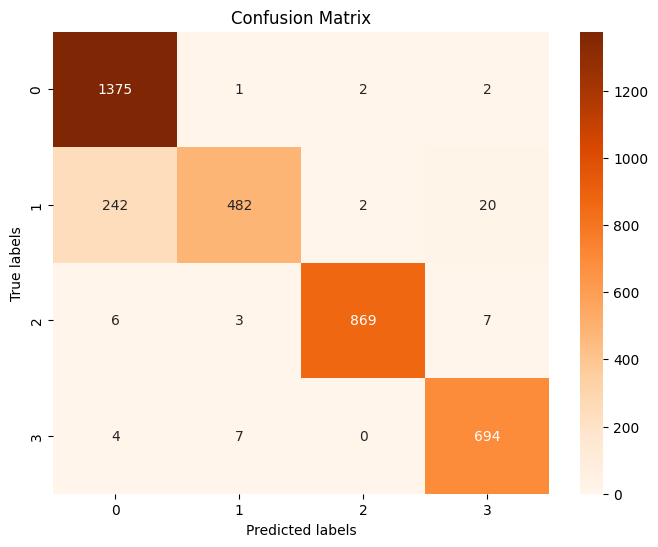

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming labels and preds are lists or arrays containing the true labels and predicted labels respectively
cm = confusion_matrix(labels, preds)

# Create a seaborn heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=True)

# Add labels and title
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")

# Show plot
plt.show()


## After full Training Run:

* Accuracy: 98.19%
* Precision: 0.98
* Recall: 0.98
* F1 Score: 0.98
* Overall Accuracy: 98.19%
* Precision per class: [0.98 0.95 1.   0.96]
* Recall per class: [0.98 0.98 0.98 0.97]
* F1 Score per class: [0.98 0.97 0.99 0.97]

In [55]:
# Show some misclassified examples
for i in range(len(labels)):
    if labels[i] != preds[i]:
        print(tokenized_datasets["test"][i]["text"])
        print("True label:", labels[i])
        print("Predicted label:", preds[i])
        print("")

. Analysen: Wir können Dritten erlauben, Analyse-Cookies zu verwenden, um zu verstehen, wie Sie unsere Websites nutzen und wir diese verbessern können. Dritte können dadurch ihre eigenen Produkte weiterentwickeln, verbessern und diese dann auf Websites nutzen, die weder Eigentum von Microsoft sind noch von Microsoft betrieben werden. Aus Soziale Medien: Wir können Social-Media-Cookies nutzen, um Ihnen Inhalte basierend auf Ihren Social-Media-Profilen und Ihren Aktivitäten auf unseren Websites anzuzeigen. Sie dienen dazu, Ihre Aktivitäten auf unseren Websites mit Ihren Social-Media-Profilen zu verbinden, sodass die Inhalte auf unseren Websites und auf Social Media Ihre Interessen künftig noch besser abbilden. Aus Werbung: Ermöglichen Sie die Verwendung von Cookies, um die Relevanz von Werbeanzeigen zu verbessern und die Beschaffung hochwertiger Inhalte auf dieser Website zu unterstützen. Wenn Sie der Verwendung von Cookies nicht zustimmen, dann sind Werbungen, die Ihnen angezeigt werden